## Setup

In [1]:
import seaborn as sns
from itertools import product
import rootplotlib as rpl
import mplhep as hep
import root_numpy
import ROOT
ROOT.gStyle.SetOptStat(0);
import numpy as np
import pandas as pd
import glob
import os
import logging
import matplotlib.pyplot as plt
from matplotlib import gridspec
from Gaugi import GeV
plt.style.use(hep.style.ROOT)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict

from packages.generators import ring_percentages, RingGenerator
from packages.plotting import make_plot_fig, cached_root2fig, root2fig, var_infos
import packages.utils as utils
from packages.constants import DROP_COLS, L1SEEDS_PER_ENERGY, CRITERIA_CONF_NAMES, ENERGY_CHAINS, TRIG_STEPS, HOME_PATH

Welcome to JupyROOT 6.16/00
Using all sub packages with ROOT dependence


In [2]:
def plot_distribution(data, model_output, var, et_cut=None, xlim=None, xlabel=None, ylabel=None, data_label=None, title=None, cmap=None, hist1d_color=None, hist1d_bins='auto'):
    fig = plt.figure(figsize=(15,10))
    axes = fig.subplots(3,1, gridspec_kw={'height_ratios':[0.1,3,1]})
    fig.patch.facetcolor=('white')
    if data_label is not None:
        data_labeling_func = getattr(utils, f'get_{data_label}_label')
        data = data[data_labeling_func(data)]
    if et_cut is not None:
        data = data[data['el_et'] < et_cut]
    if xlim is not None:
        data = data[data[var].between(*xlim, inclusive='both')]
    sns.histplot(data, x=var, y=model_output, 
                 thresh=0, cmap=cmap, ax=axes[1], cbar=True, cbar_ax=axes[0], cbar_kws=dict(orientation="horizontal"))
    axes[1].set_xlabel('')
    axes[0].xaxis.tick_top()
    if xlim is not None:
        axes[1].set_xlim(*xlim)
    axes[1].text(0.85, 0.1, f'Samples: {len(data)}', transform=axes[1].transAxes, fontsize=14,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    sns.histplot(data, x=var, thresh=0, 
                 ax=axes[2], color=hist1d_color, bins=hist1d_bins)
    if xlabel is not None:
        axes[2].set_xlabel(xlabel, loc='left', fontsize='large')
    if ylabel is not None:
        axes[1].set_ylabel(ylabel, fontsize='large')
    if xlim is not None:
        axes[1].set_xlim(*xlim)
        axes[2].set_xlim(*xlim)
    if title is not None:
        axes[0].set_title(title, fontsize='x-large')
    return fig, axes

## Parameters

In [3]:
datasetpath = os.path.join(HOME_PATH, 
   'data/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins.v2')

modelpaths = [
    'tunings/TrigL2_20180125_v8',
    'tunings/TrigL2_20210907_v12 (v8.1-2)'
    'tunings/TrigL2_20220704_v20',
    'tunings/TrigL2_20220802_v20.1',
    'tunings/TrigL2_20210306_v10',
    'tunings/TrigL2_20220822_v10.1'
]

output_dir = 'analysis/chain_simulation_test'
plot_vars = ['et', 'eta', 'pt', 'mu', 'dr']
data_labels = ['electron']

dev = False
log = False

colors = [1, 601, 417, 633, 616, 401, 922]
markers = [33, 22, 23, 30, 20, 34, 21]

# Initializing logger
plot_logger = utils.get_logger('plot_vars_distributions', file=log)



## Getting models

In [4]:
plot_logger.info('Getting models')
trigger_strategies = []
aux_conf_name = CRITERIA_CONF_NAMES['tight']
for modelpath in modelpaths:
    confpath = os.path.join(modelpath, aux_conf_name)
    env = ROOT.TEnv(confpath)
    ringer_version = env.GetValue("__version__", '')
    ringer_name = f'ringer_{ringer_version}'
    trigger_strategies.append(ringer_name)

2022-08-31 17:02:37,437 - Loading chains


## Plotting

2022-08-31 17:03:01,438 - Loading: ringer_v8.parquet
2022-08-31 17:03:01,527 - Plotting var et for ringer_v8
2022-08-31 17:03:02,107 - Plotting var eta for ringer_v8
2022-08-31 17:03:02,691 - Plotting var pt for ringer_v8
2022-08-31 17:03:03,532 - Plotting var mu for ringer_v8
2022-08-31 17:03:04,231 - Plotting var dr for ringer_v8
2022-08-31 17:03:04,847 - Loading: ringer_v12.parquet
2022-08-31 17:03:05,020 - Plotting var et for ringer_v12
2022-08-31 17:03:05,627 - Plotting var eta for ringer_v12
2022-08-31 17:03:06,237 - Plotting var pt for ringer_v12
2022-08-31 17:03:06,962 - Plotting var mu for ringer_v12
2022-08-31 17:03:07,757 - Plotting var dr for ringer_v12


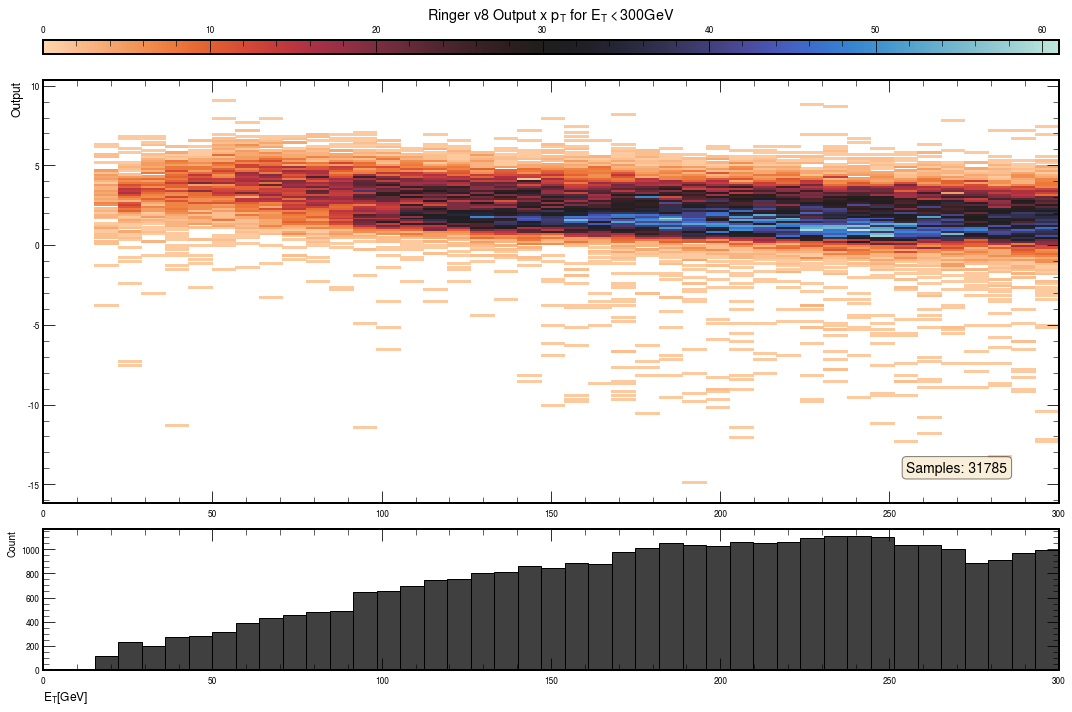

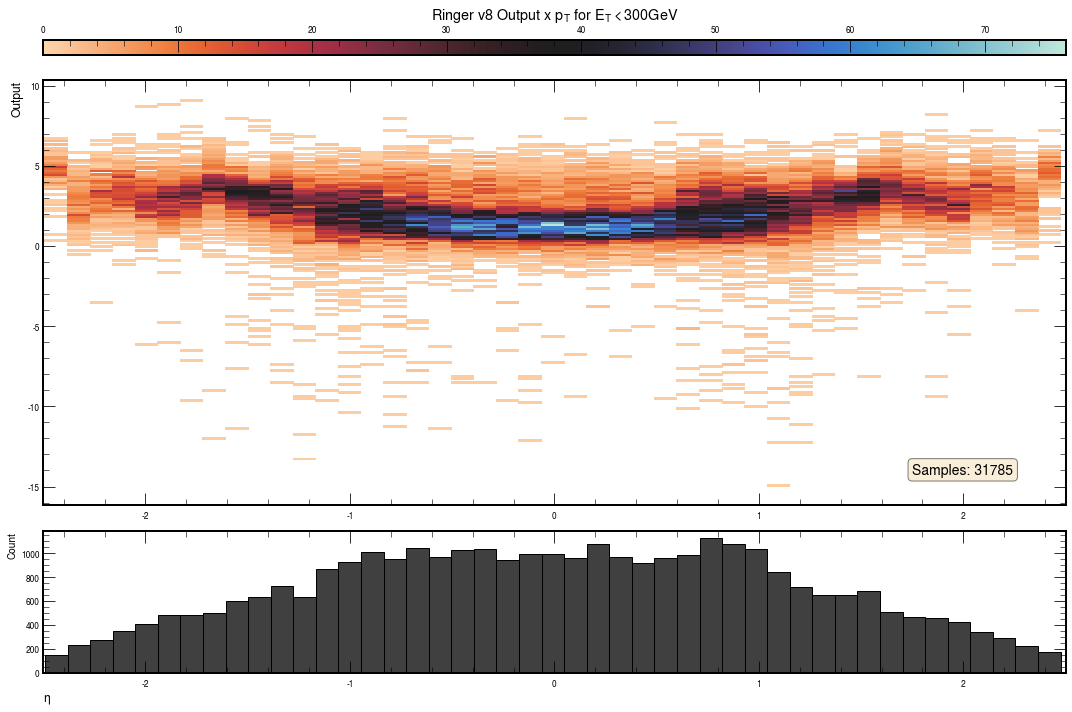

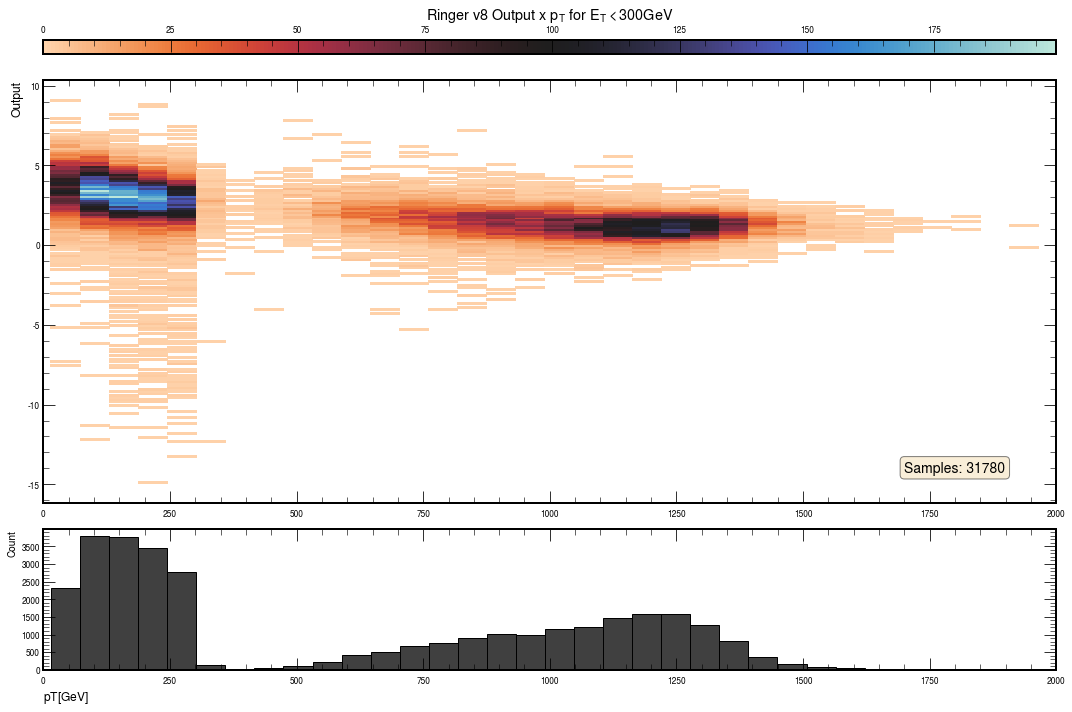

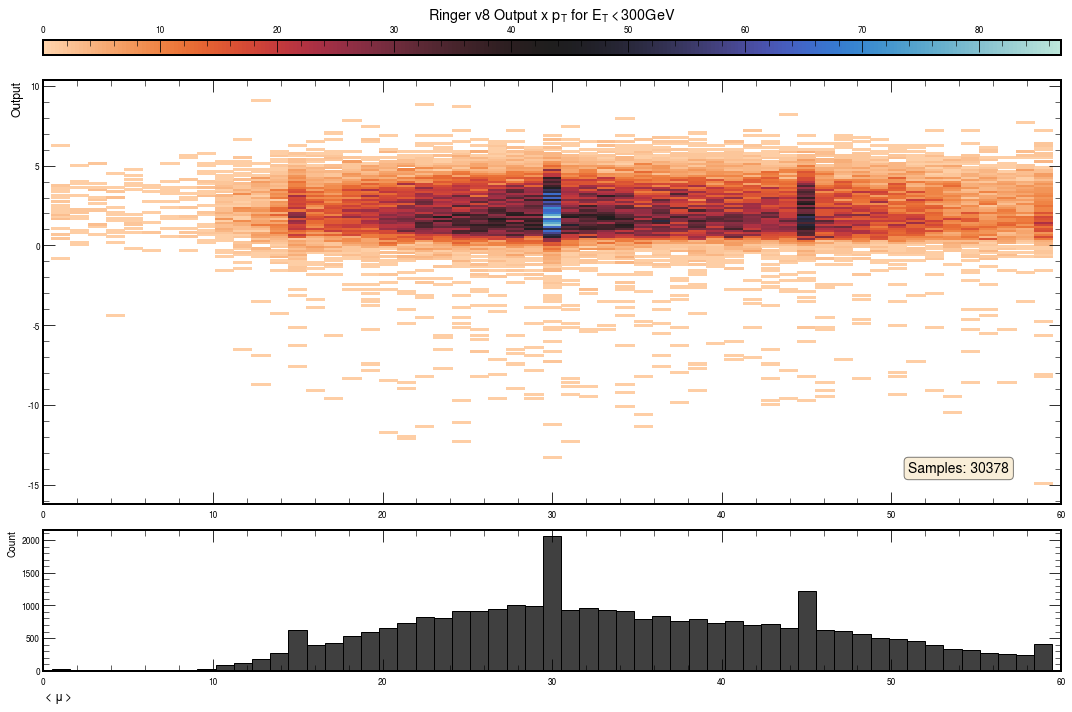

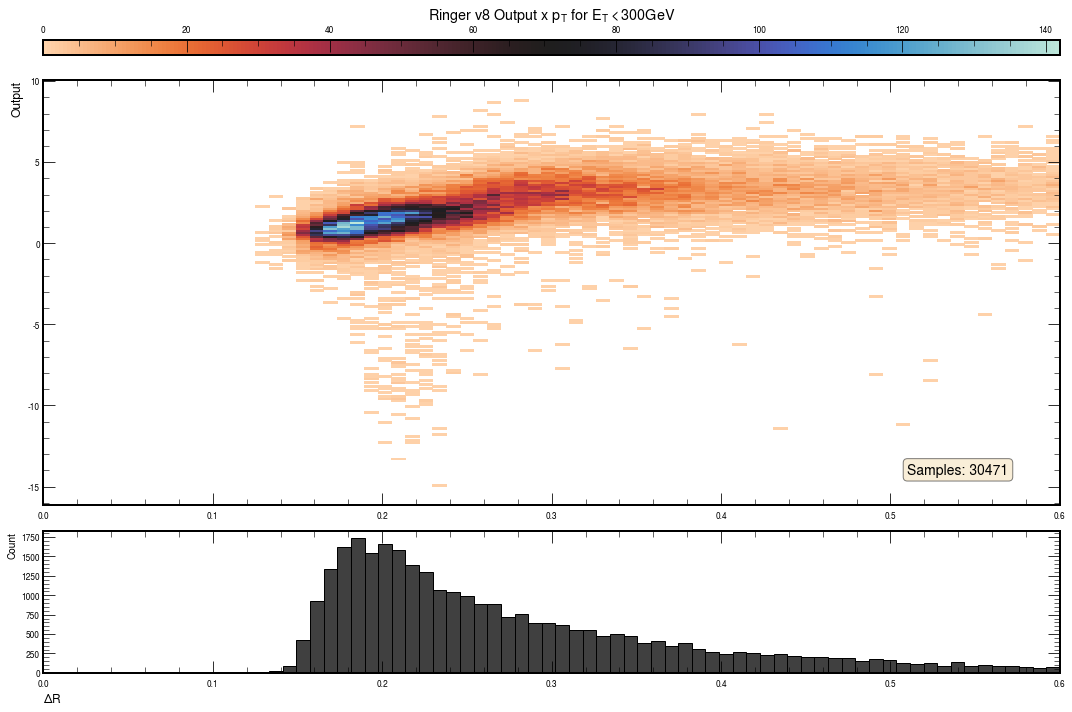

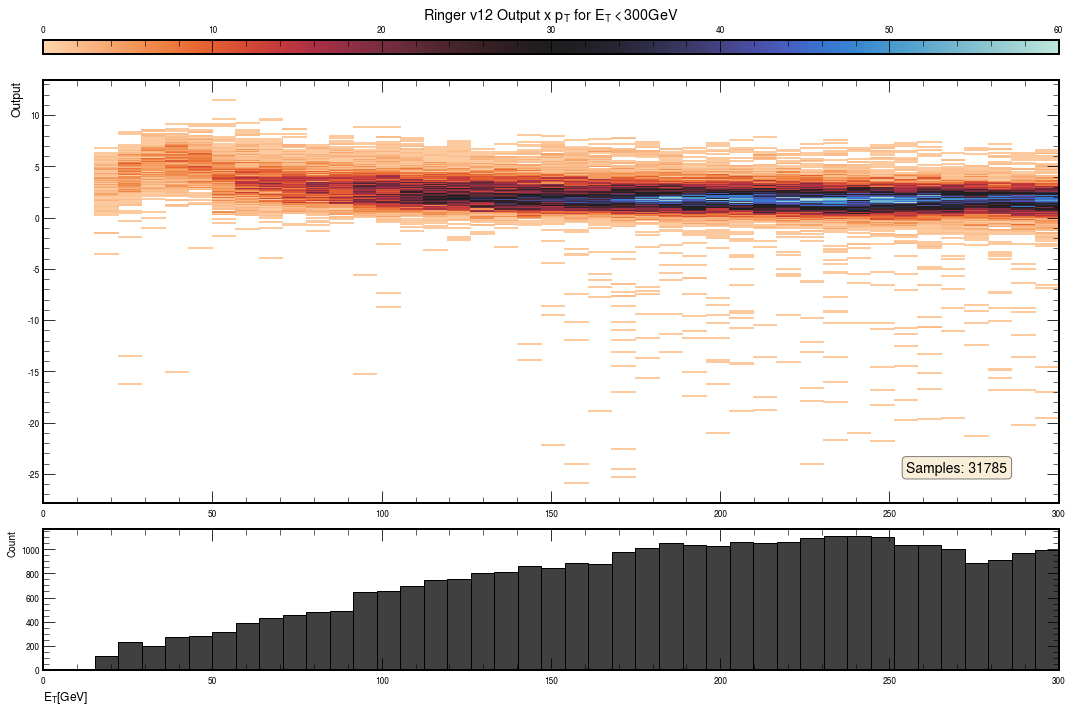

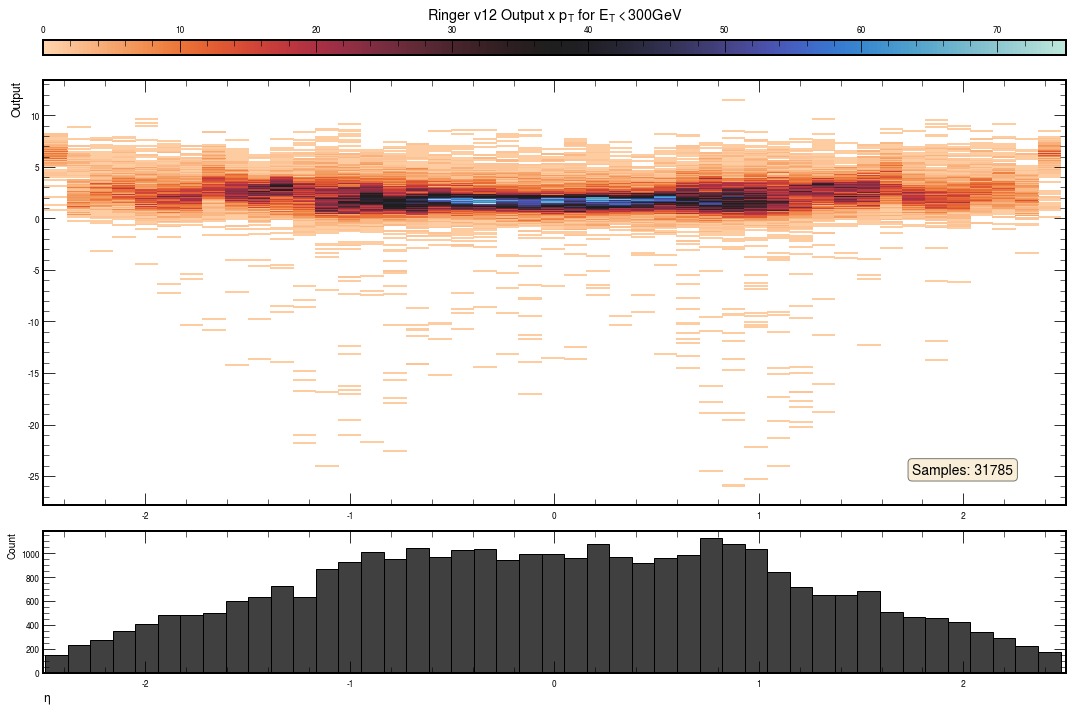

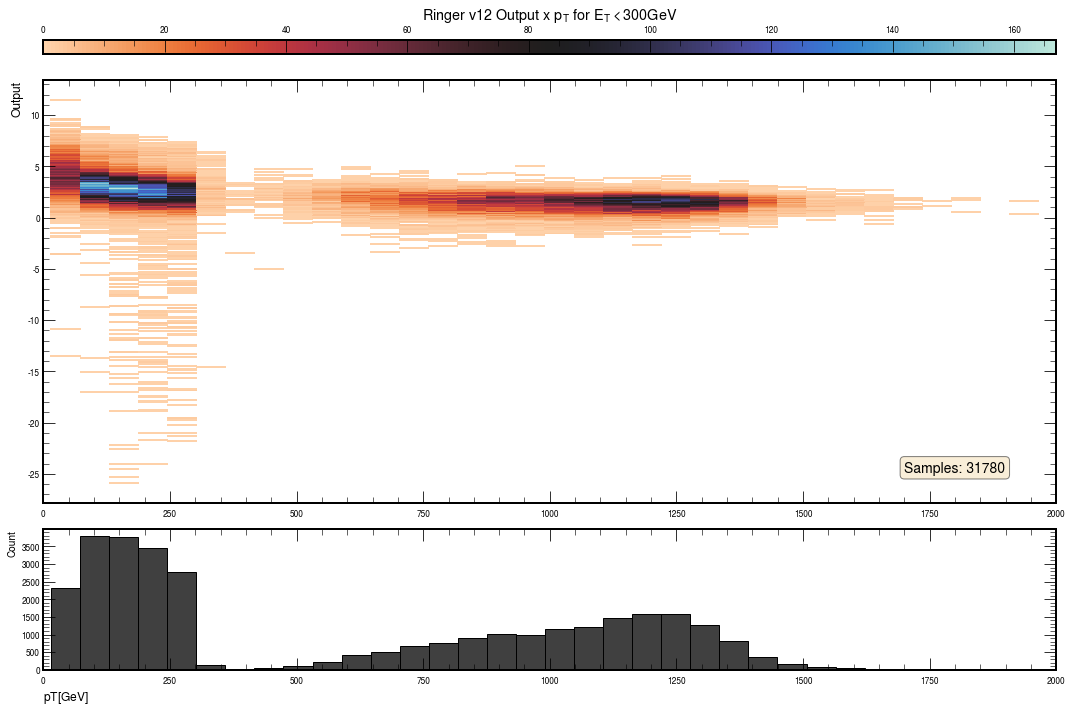

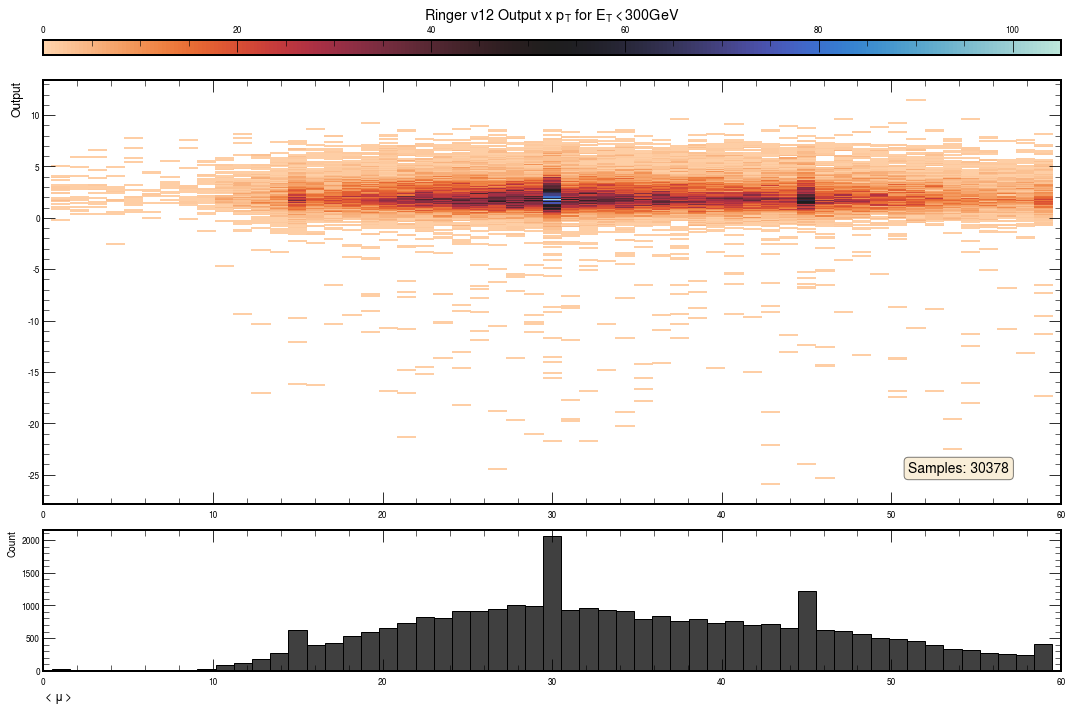

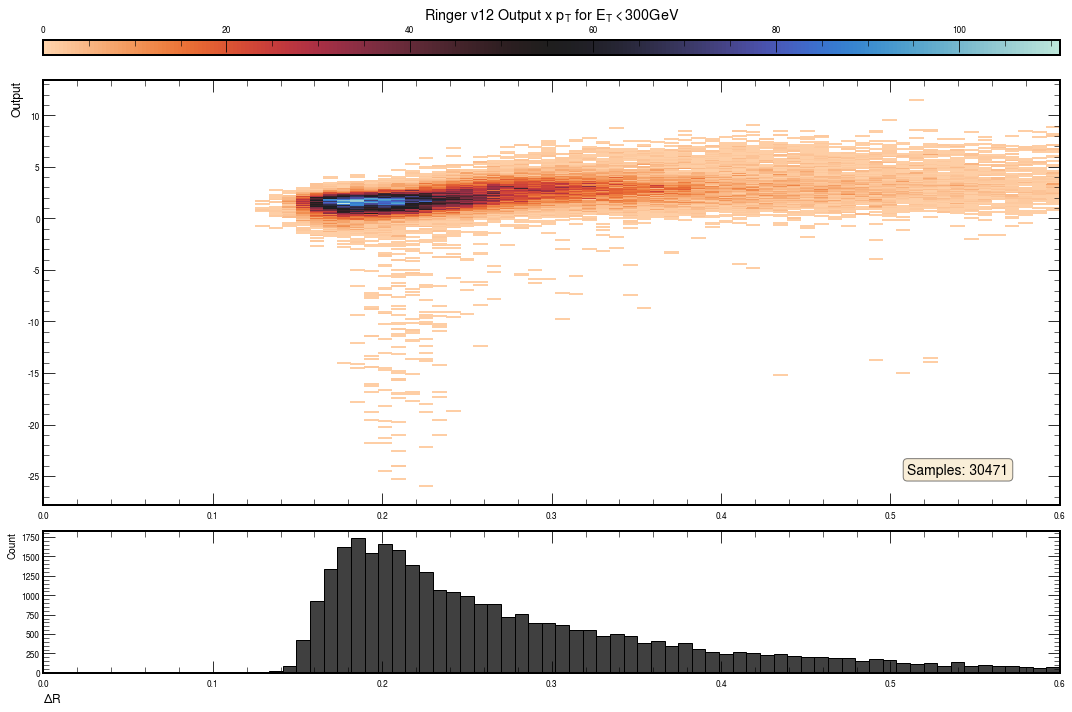

In [7]:
plots = dict()
lims = dict(pt=(0,2000), et=(0,300), dr=(0,0.6), mu=(0,60), eta=(-2.5,2.5))
for trig_strat in trigger_strategies:
    var_plots = dict()
    plots[trig_strat] = var_plots
    parquet_file = trig_strat + '.parquet'
    chainpath = os.path.join(datasetpath, 'simulated_chains', parquet_file)
    if dev:
        chainpath = os.path.join(chainpath, f'{trig_strat}_et4_eta4.parquet')
    plot_logger.info(f'Loading: {parquet_file}')
    data = pd.read_parquet(chainpath)
    data[var_infos['pt']['col']] = data[var_infos['pt']['col']]/GeV
    data[var_infos['et']['col']] = data[var_infos['et']['col']]/GeV
    for var, data_label in product(plot_vars, data_labels):
        plot_logger.info(f'Plotting var {var} for {trig_strat}')
        strat_name = trig_strat.capitalize().replace('_', ' ')
        text_label = var_infos[var]["label"].replace('#', '\\')
        fig, axes = plot_distribution(data, f'{trig_strat}_tight_output', var_infos[var]['col'], 
                                      xlim=lims[var], xlabel=fr'${text_label}$', ylabel='Output', et_cut=300, data_label=data_label,
                                      title = fr'{strat_name} Output x ${text_label}$ for $E_T < 300 GeV$', cmap="icefire_r", hist1d_color='black')
        fig.tight_layout()
        plot_output_dir = os.path.join(output_dir, f'output_distributions_{data_label}', var)
        if not os.path.exists(plot_output_dir):
            os.makedirs(plot_output_dir)
        fig.savefig(os.path.join(plot_output_dir, f'{var}_{trig_strat}_{data_label}_distribution.png'), transparent=False, facecolor='white')
        var_plots[var] = (fig, axes)

In [56]:
plot_logger.info('Finished')